# **DeepBedMap**

Predicting the bed elevation of Antarctica using a Super Resolution Deep Neural Network.

In [1]:
import math
import os
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import comet_ml
import cupy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import quilt
import rasterio
import skimage
import xarray as xr

import chainer

from features.environment import _load_ipynb_modules

data_prep = _load_ipynb_modules("data_prep.ipynb")

## Get bounding box of area we want to predict on

In [2]:
def get_image_and_bounds(filepaths: list) -> (np.ndarray, rasterio.coords.BoundingBox):
    """
    Retrieve raster image in numpy array format and
    geographic bounds as (xmin, ymin, xmax, ymax)

    Note that if more than one filepath is passed in,
    the output groundtruth image array will not be valid
    (see https://github.com/pydata/xarray/issues/2159),
    but the window_bound extents will be correct
    """
    if len(filepaths) > 1:
        print("WARN: using multiple inputs, output groundtruth image will look funny")

    with xr.open_mfdataset(paths=filepaths, concat_dim=None) as data:
        groundtruth = data.z.to_masked_array()
        groundtruth = np.flipud(groundtruth)  # flip on y-axis...
        groundtruth = np.expand_dims(
            np.expand_dims(groundtruth, axis=0), axis=0
        )  # add extra dimensions (batch and channel)
        assert groundtruth.shape[0:2] == (1, 1)  # check that shape is like (1, 1, h, w)

        xmin, xmax = float(data.x.min()), float(data.x.max())
        ymin, ymax = float(data.y.min()), float(data.y.max())

        window_bound = rasterio.coords.BoundingBox(
            left=xmin, bottom=ymin, right=xmax, top=ymax
        )
    return groundtruth, window_bound

In [3]:
test_filepaths = ["highres/2007tx", "highres/2010tr", "highres/istarxx"]
groundtruth, window_bound = get_image_and_bounds(
    filepaths=[f"{t}.nc" for t in test_filepaths]
)

WARN: using multiple inputs, output groundtruth image will look funny


## Get neural network input datasets for our area of interest

In [4]:
def get_deepbedmap_model_inputs(
    window_bound: rasterio.coords.BoundingBox, padding=1000
) -> typing.Dict[str, np.ndarray]:
    """
    Outputs one large tile for each of
    BEDMAP2, REMA and MEASURES Ice Flow Velocity
    according to a given window_bound in the form of
    (xmin, ymin, xmax, ymax).
    """
    data_prep = _load_ipynb_modules("data_prep.ipynb")

    X_tile = data_prep.selective_tile(
        filepath="lowres/bedmap2_bed.tif",
        window_bounds=[[*window_bound]],
        padding=padding,
    )
    W2_tile = data_prep.selective_tile(
        filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif",
        window_bounds=[[*window_bound]],
        out_shape=(2 * X_tile.shape[2], 2 * X_tile.shape[3]),
        padding=padding,
        gapfill_raster_filepath="misc/lisa750_2013182_2017120_0000_0400_vv_v1_myr.tif",
    )
    W1_tile = data_prep.selective_tile(
        filepath="misc/REMA_100m_dem.tif",
        window_bounds=[[*window_bound]],
        padding=padding,
        gapfill_raster_filepath="misc/REMA_200m_dem_filled.tif",
    )

    return X_tile, W1_tile, W2_tile

In [5]:
def plot_3d_view(
    img: np.ndarray,
    ax: matplotlib.axes._subplots.Axes,
    elev: int = 60,
    azim: int = 330,
    cm_norm: matplotlib.colors.Normalize = None,
    title: str = None,
):
    # Get x, y, z data, assuming image in NCHW format
    image = img[0, :, :, :]
    xx, yy = np.mgrid[0 : image.shape[1], 0 : image.shape[2]]
    zz = image[0, :, :]

    # Make the 3D plot
    ax.view_init(elev=elev, azim=azim)
    ax.plot_surface(xx, yy, zz, cmap="BrBG", norm=cm_norm)
    ax.set_title(label=f"{title}\n", fontsize=22)

    return ax

In [6]:
X_tile, W1_tile, W2_tile = get_deepbedmap_model_inputs(window_bound=window_bound)

# Build quilt package for datasets covering our test region
reupload = False
if reupload == True:
    quilt.build(package="weiji14/deepbedmap/model/test/W1_tile", path=W1_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/W2_tile", path=W2_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/X_tile", path=X_tile)
    quilt.push(package="weiji14/deepbedmap/model/test", is_public=True)

Tiling: lowres/bedmap2_bed.tif ... done!
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif ... done!
Tiling: misc/REMA_100m_dem.tif ... done!


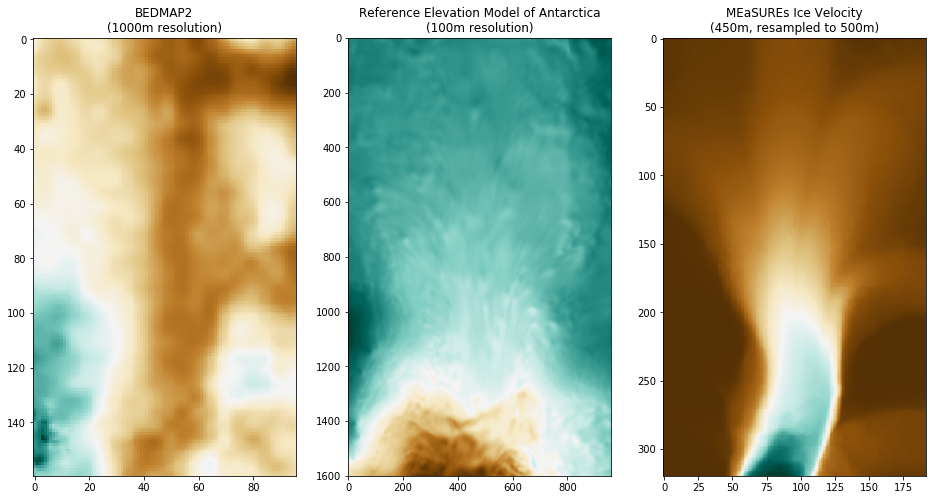

In [7]:
fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2\n(1000m resolution)")
axarr[0, 1].imshow(W1_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Reference Elevation Model of Antarctica\n(100m resolution)")
axarr[0, 2].imshow(W2_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("MEaSUREs Ice Velocity\n(450m, resampled to 500m)")
plt.show()

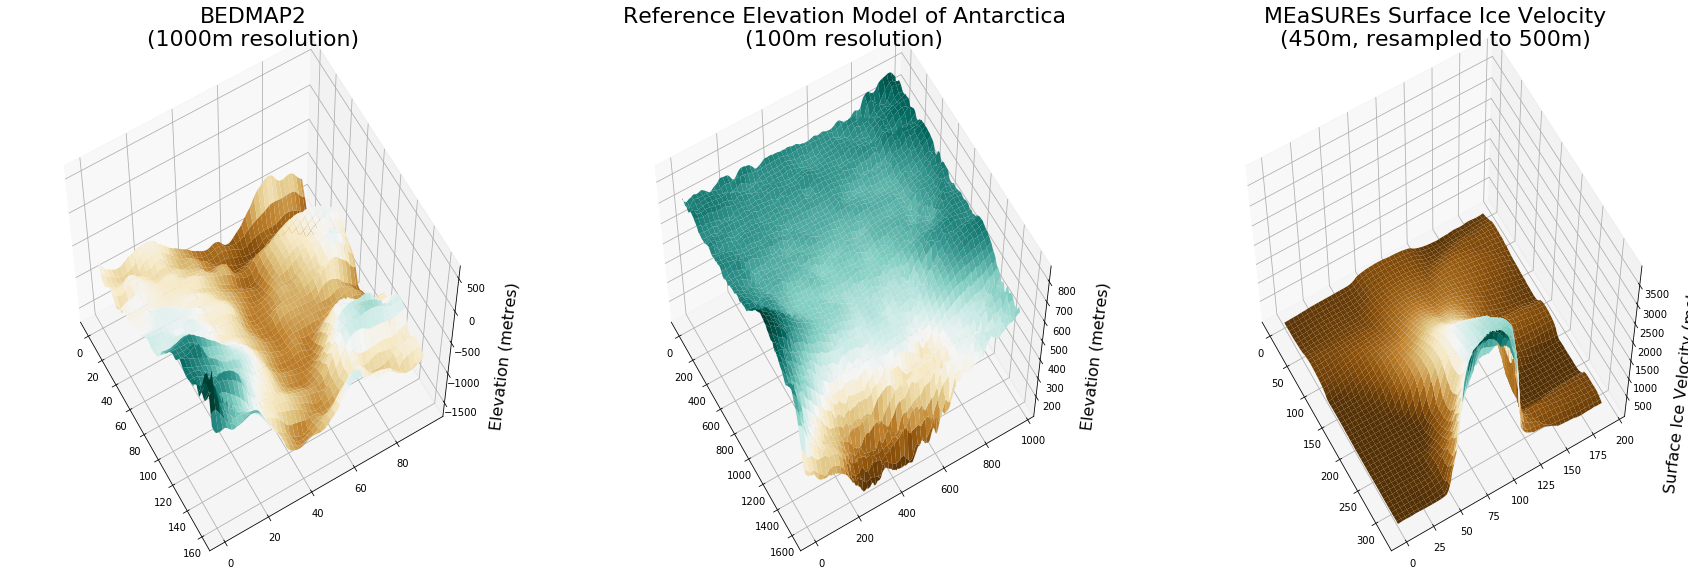

In [8]:
fig = plt.figure(figsize=plt.figaspect(1 / 3) * 2.5)

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax = plot_3d_view(img=X_tile, ax=ax, title="BEDMAP2\n(1000m resolution)")
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 3, 2, projection="3d")
ax = plot_3d_view(
    img=W1_tile,
    ax=ax,
    title="Reference Elevation Model of Antarctica\n(100m resolution)",
)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax = plot_3d_view(
    img=W2_tile, ax=ax, title="MEaSUREs Surface Ice Velocity\n(450m, resampled to 500m)"
)
ax.set_zlabel("\n\nSurface Ice Velocity (metres/year)", fontsize=16)

plt.show()

## Create custom neural network for our area of interest

Fully convolutional networks rock!!
Since we have a fully convolutional model architecture,
we can change the shape of the inputs/outputs,
but use the same trained weights!
That way we can predict directly on an arbitrarily sized window.

In [9]:
def load_trained_model(
    model=None,
    model_weights_path: str = "model/weights/srgan_generator_model_weights.npz",
):
    """
    Builds the Generator component of the DeepBedMap neural network.
    Also loads trained parameter weights into the model from a .npz file.
    """
    srgan_train = _load_ipynb_modules("srgan_train.ipynb")

    if model is None:
        model = srgan_train.GeneratorModel(
            # num_residual_blocks=12,
            # residual_scaling=0.4,
        )

    # Load trained neural network weights into model
    chainer.serializers.load_npz(file=model_weights_path, obj=model)

    return model

## Make prediction

In [10]:
model = load_trained_model()

In [11]:
# Prediction on small area
Y_hat = model.forward(x=X_tile, w1=W1_tile, w2=W2_tile).array

## Load other interpolated grids for comparison

- Bicubic interpolated BEDMAP2
- Synthetic High Resolution Grid from [Graham et al.](https://doi.org/10.5194/essd-9-267-2017)

In [12]:
cubicbedmap2 = skimage.transform.rescale(
    image=X_tile[0, 0, 1:-1, 1:-1].astype(np.int32),
    scale=4,  # 4x upscaling
    order=3,  # cubic interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
cubicbedmap2 = np.expand_dims(np.expand_dims(cubicbedmap2, axis=0), axis=0)
print(cubicbedmap2.shape, Y_hat.shape)
assert cubicbedmap2.shape == Y_hat.shape

(1, 1, 632, 376) (1, 1, 632, 376)


In [13]:
S_tile = data_prep.selective_tile(
    filepath="model/hres.tif", window_bounds=[[*window_bound]]
)

Tiling: model/hres.tif ... done!


## Plot results

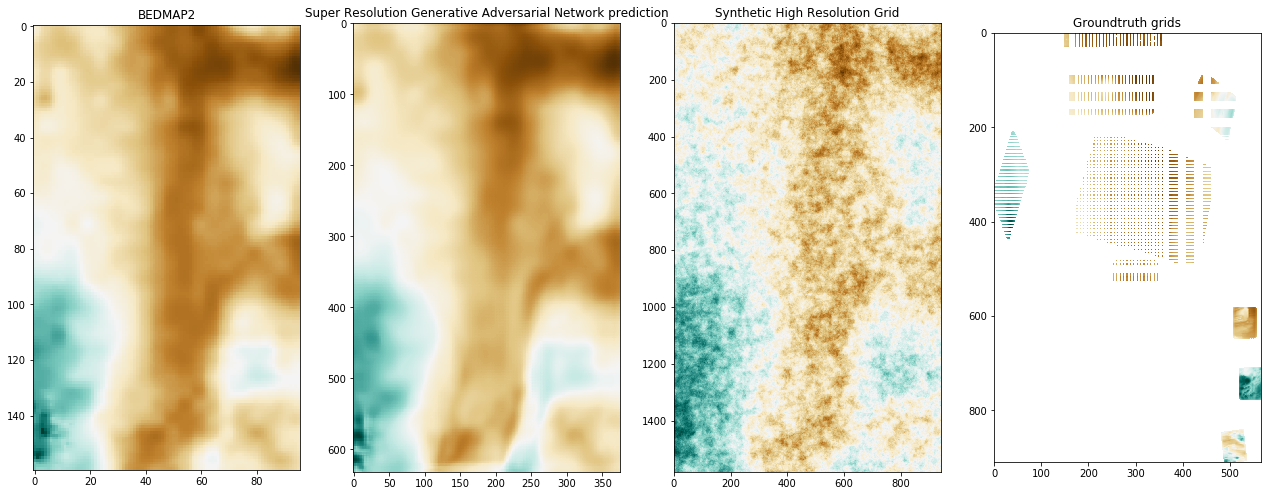

In [14]:
fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(22, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2")
axarr[0, 1].imshow(Y_hat[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Super Resolution Generative Adversarial Network prediction")
axarr[0, 2].imshow(S_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("Synthetic High Resolution Grid")
axarr[0, 3].imshow(groundtruth[0, 0, :, :], cmap="BrBG")
axarr[0, 3].set_title("Groundtruth grids")
plt.show()

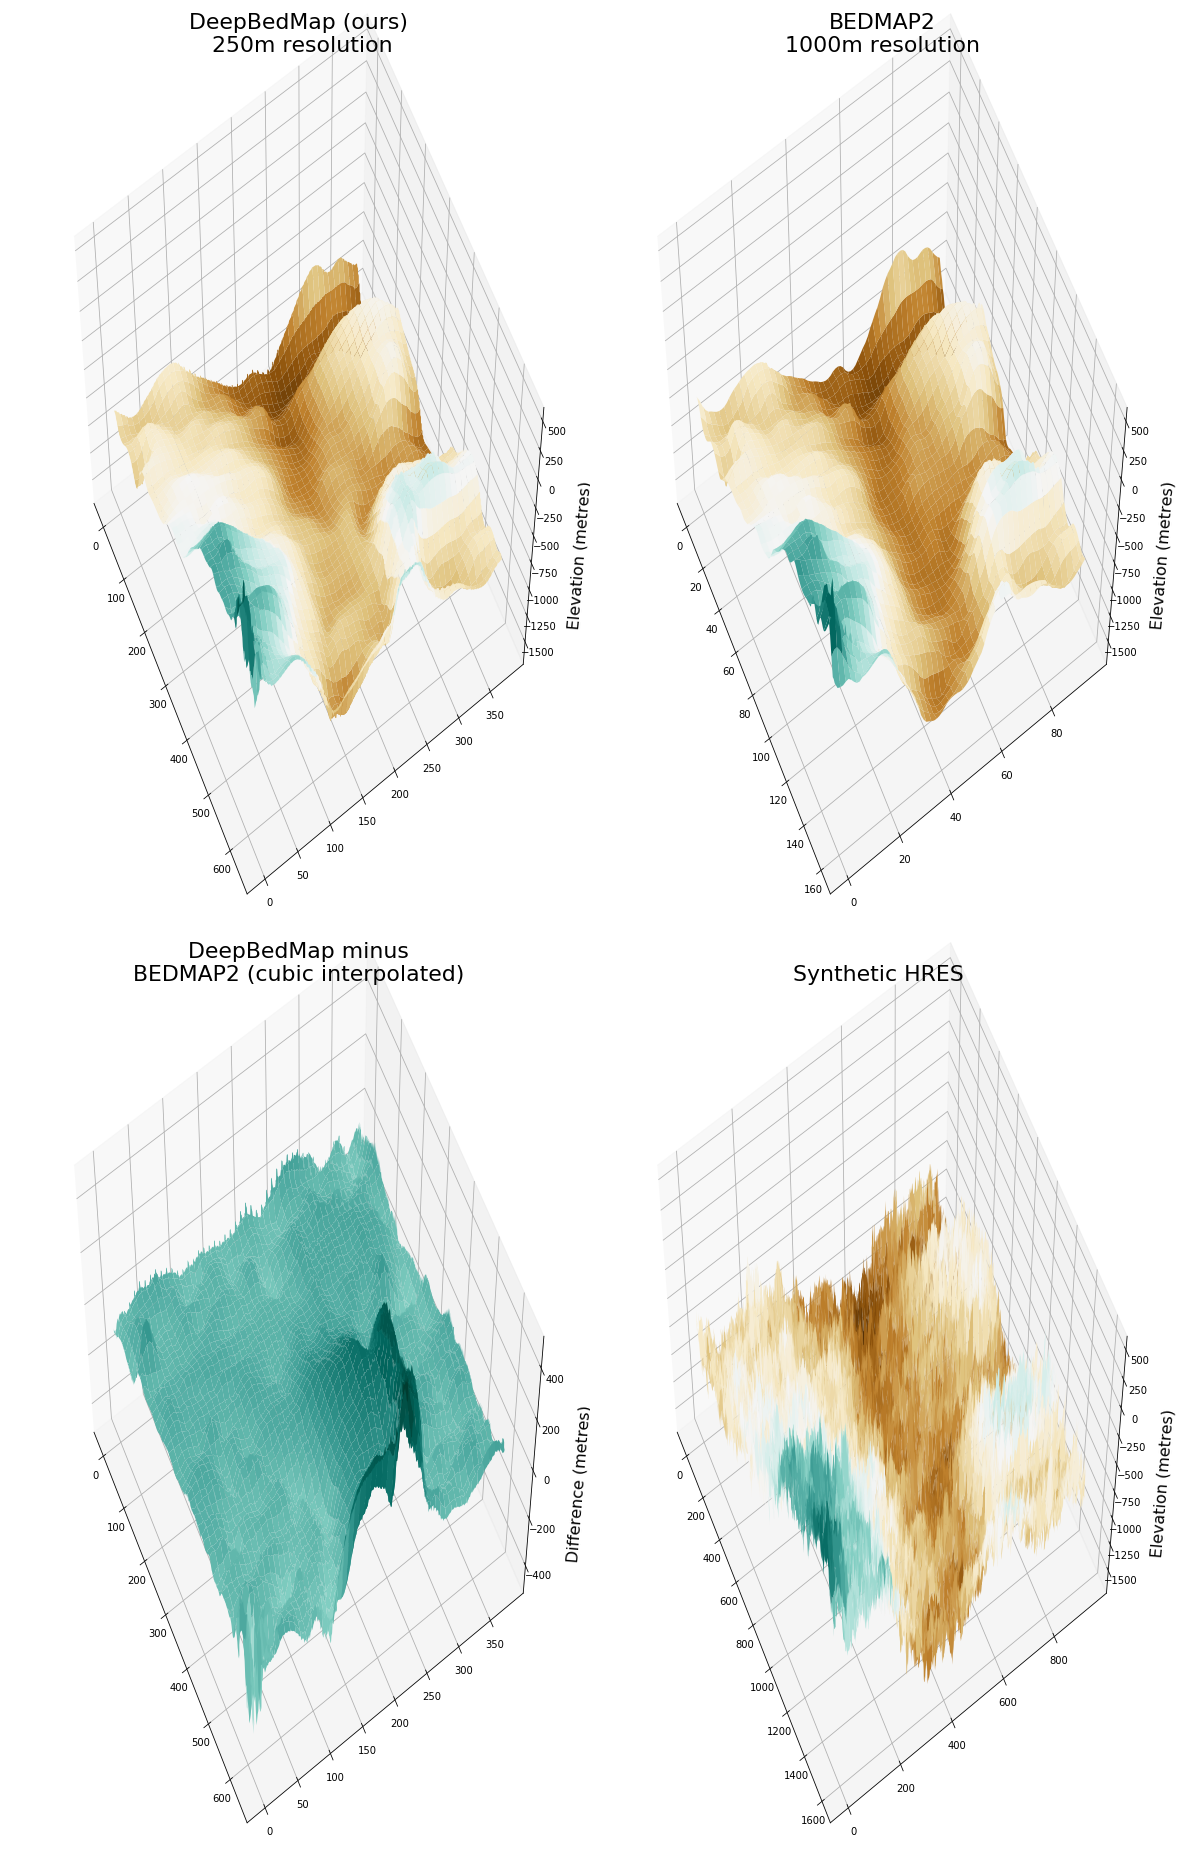

In [15]:
fig = plt.figure(figsize=plt.figaspect(12 / 9) * 4.5)  # (height/width)*scaling

zmin, zmax = (Y_hat.min(), Y_hat.max())
norm_Z = matplotlib.cm.colors.Normalize(vmin=zmin, vmax=zmax)

# DeepBedMap
ax = fig.add_subplot(2, 2, 1, projection="3d")
ax = plot_3d_view(
    img=Y_hat, ax=ax, cm_norm=norm_Z, title="DeepBedMap (ours)\n 250m resolution"
)
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

# BEDMAP2
ax = fig.add_subplot(2, 2, 2, projection="3d")
ax = plot_3d_view(img=X_tile, ax=ax, cm_norm=norm_Z, title="BEDMAP2\n1000m resolution")
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

# DeepBedMap - BEDMAP2
ax = fig.add_subplot(2, 2, 3, projection="3d")
ax = plot_3d_view(
    img=Y_hat - cubicbedmap2,
    ax=ax,
    cm_norm=norm_Z,
    title="DeepBedMap minus\nBEDMAP2 (cubic interpolated)",
)
ax.set_zlim(bottom=-500, top=500)
ax.set_zlabel("\n\nDifference (metres)", fontsize=16)

# Synthetic
ax = fig.add_subplot(2, 2, 4, projection="3d")
ax = plot_3d_view(img=S_tile, ax=ax, cm_norm=norm_Z, title="Synthetic HRES ")
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

plt.subplots_adjust(wspace=0.0001, hspace=0.0001, left=0.0, right=0.9, top=1.2)
plt.savefig(fname="esrgan_prediction.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Save Bicubic BEDMAP2 and ESRGAN DeepBedMap to a grid file

In [16]:
def save_array_to_grid(
    window_bound: tuple, array: np.ndarray, outfilepath: str, dtype: str = None
):
    """
    Saves a numpy array to geotiff and netcdf format.
    Appends ".tif" and ".nc" file extension to the outfilepath
    for geotiff and netcdf outputs respectively.
    """

    assert array.ndim == 4
    assert array.shape[1] == 1  # check that there is only one channel

    transform = rasterio.transform.from_bounds(
        *window_bound, height=array.shape[2], width=array.shape[3]
    )

    # Save array as a GeoTiff first
    with rasterio.open(
        f"{outfilepath}.tif",
        mode="w",
        driver="GTiff",
        height=array.shape[2],
        width=array.shape[3],
        count=1,
        crs="EPSG:3031",
        transform=transform,
        dtype=array.dtype if dtype is None else dtype,
        nodata=-2000,
    ) as new_geotiff:
        new_geotiff.write(array[0, 0, :, :], 1)

    # Convert deepbedmap3 and cubicbedmap2 from geotiff to netcdf format
    xr.open_rasterio(f"{outfilepath}.tif").to_netcdf(f"{outfilepath}.nc")

In [17]:
# Save BEDMAP3 to GeoTiff and NetCDF format
save_array_to_grid(
    window_bound=window_bound, array=Y_hat, outfilepath="model/deepbedmap3"
)

In [18]:
# Save Bicubic Resampled BEDMAP2 to GeoTiff and NetCDF format
save_array_to_grid(
    window_bound=window_bound, array=cubicbedmap2, outfilepath="model/cubicbedmap"
)

In [19]:
synthetic = skimage.transform.rescale(
    image=S_tile[0, 0, :, :].astype(np.int32),
    scale=1 / 2.5,  # 2.5 downscaling
    order=1,  # billinear interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
save_array_to_grid(
    window_bound=window_bound,
    array=np.expand_dims(np.expand_dims(synthetic, axis=0), axis=0),
    outfilepath="model/synthetichr",
)

# Crossover analysis

We use [grdtrack](https://gmt.soest.hawaii.edu/doc/latest/grdtrack) to sample our grid along the survey tracks.

The survey tracks are basically geographic xy points flown by a plane.
The three grids are all 250m spatial resolution, and they are:

- Groundtruth grid (interpolated from our groundtruth points using [surface](https://gmt.soest.hawaii.edu/doc/latest/surface.html))
- DeepBedMap3 grid (predicted from our [Super Resolution Generative Adversarial Network model](/srgan_train.ipynb))
- CubicBedMap grid (interpolated from BEDMAP2 using a [bicubic spline algorithm](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale))

Reference:

Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package. Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [20]:
test_filepath = "highres/2007tx"  # only one NetCDF grid can be tested
track_test = data_prep.ascii_to_xyz(pipeline_file=f"{test_filepath}.json")
track_test.to_csv("track_test.xyz", sep="\t", index=False)

In [21]:
## TODO make this multi-grid method work...
# track_test = pd.concat(
#     objs=[data_prep.ascii_to_xyz(pipeline_file=f"{pf}.json") for pf in test_filepaths]
# )
# grids = r"\n".join(f"{grid}.nc" for grid in test_filepaths)
# print(grids)
# !echo "{grids}" > tmp.txt
# !gmt grdtrack track_test.xyz -G+ltmp.txt -h1 -i0,1,2 > track_groundtruth.xyzi

In [22]:
!gmt grdtrack track_test.xyz -G{test_filepath}.nc -h1 -i0,1,2 > track_groundtruth.xyzi
!gmt grdtrack track_test.xyz -Gmodel/deepbedmap3.nc -h1 -i0,1,2 > track_deepbedmap3.xyzi
!gmt grdtrack track_test.xyz -Gmodel/cubicbedmap.nc -h1 -i0,1,2 > track_cubicbedmap.xyzi
!gmt grdtrack track_test.xyz -Gmodel/synthetichr.nc -h1 -i0,1,2 > track_synthetichr.xyzi
!head track_*.xyzi -n5

==> track_cubicbedmap.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1157.15295916
-1593491.331	-104797.7531	-1074.68	-1157.23202788
-1593486.331	-104797.7058	-1074.683558	-1157.31140196
-1593481.331	-104797.6599	-1074.695031	-1157.3910509

==> track_deepbedmap3.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1178.55372742
-1593491.331	-104797.7531	-1074.68	-1178.65221589
-1593486.331	-104797.7058	-1074.683558	-1178.7539771
-1593481.331	-104797.6599	-1074.695031	-1178.85881445

==> track_groundtruth.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1076.93163393
-1593491.331	-104797.7531	-1074.68	-1077.02038288
-1593486.331	-104797.7058	-1074.683558	-1077.11179311
-1593481.331	-104797.6599	-1074.695031	-1077.20604871

==> track_synthetichr.xyzi <==
# x	y	z
-1593496.33	-104797.8003	-1074.669904	-1540.03173515
-1593491.331	-104797.7531	-1074.68	-1540.35348415
-1593486.331	-104797.7058	-1074.683558	-1540.66279953
-1593481.331	-104797.6599	-1074.695031	-1540.95828362

### Get table statistics

In [23]:
names = ["x", "y", "z", "z_interpolated"]
df_groundtruth = pd.read_csv("track_groundtruth.xyzi", sep="\t", header=1, names=names)
df_deepbedmap3 = pd.read_csv("track_deepbedmap3.xyzi", sep="\t", header=1, names=names)
df_cubicbedmap = pd.read_csv("track_cubicbedmap.xyzi", sep="\t", header=1, names=names)
df_synthetichr = pd.read_csv("track_synthetichr.xyzi", sep="\t", header=1, names=names)

In [24]:
df_groundtruth["error"] = df_groundtruth.z_interpolated - df_groundtruth.z
df_groundtruth.describe()

,x,y,z,z_interpolated,error
count,4.251900e+04,42519.000000,42519.000000,42519.000000,42519.000000
mean,-1.582757e+06,-127325.264835,-1254.856877,-1255.085246,-0.228368
std,4.508689e+03,29482.513828,75.079124,74.385125,7.314787
min,-1.593714e+06,-164173.784800,-1390.940804,-1382.213580,-112.671590
25%,-1.585651e+06,-160928.278350,-1327.666236,-1327.409421,-1.765492
50%,-1.581923e+06,-104330.745000,-1251.150818,-1246.127694,-0.061275
75%,-1.579367e+06,-101358.125200,-1195.045000,-1196.828030,1.379292
max,-1.575464e+06,-97923.920590,-962.574500,-1045.562709,46.403994


In [25]:
df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
df_deepbedmap3.describe()

,x,y,z,z_interpolated,error
count,4.221100e+04,42211.000000,42211.000000,42211.000000,42211.000000
mean,-1.582777e+06,-127564.699347,-1254.439065,-1291.730251,-37.291185
std,4.525480e+03,29459.491355,75.190474,70.403221,28.625294
min,-1.593714e+06,-164173.784800,-1390.940804,-1453.076618,-227.671373
25%,-1.585726e+06,-160955.405850,-1327.659392,-1367.242464,-50.661219
50%,-1.581987e+06,-104338.540000,-1246.133927,-1247.272402,-38.351570
75%,-1.579398e+06,-101436.367650,-1194.896816,-1232.019155,-22.959548
max,-1.575435e+06,-98049.214190,-962.574500,-1152.221308,46.995418


In [26]:
df_cubicbedmap["error"] = df_cubicbedmap.z_interpolated - df_cubicbedmap.z
df_cubicbedmap.describe()

,x,y,z,z_interpolated,error
count,4.221100e+04,42211.000000,42211.000000,42211.000000,42211.000000
mean,-1.582777e+06,-127564.699347,-1254.439065,-1305.538648,-51.099583
std,4.525480e+03,29459.491355,75.190474,53.540358,38.192042
min,-1.593714e+06,-164173.784800,-1390.940804,-1388.030184,-206.521325
25%,-1.585726e+06,-160955.405850,-1327.659392,-1353.523793,-85.519458
50%,-1.581987e+06,-104338.540000,-1246.133927,-1293.887599,-50.098669
75%,-1.579398e+06,-101436.367650,-1194.896816,-1276.961914,-26.762773
max,-1.575435e+06,-98049.214190,-962.574500,-1149.705271,65.416914


In [27]:
df_synthetichr["error"] = df_synthetichr.z_interpolated - df_synthetichr.z
df_synthetichr.describe()

,x,y,z,z_interpolated,error
count,4.221100e+04,42211.000000,42211.000000,42211.000000,42211.000000
mean,-1.582777e+06,-127564.699347,-1254.439065,-1278.316973,-23.877907
std,4.525480e+03,29459.491355,75.190474,135.691340,155.139257
min,-1.593714e+06,-164173.784800,-1390.940804,-1683.044812,-468.102357
25%,-1.585726e+06,-160955.405850,-1327.659392,-1366.590182,-129.114095
50%,-1.581987e+06,-104338.540000,-1246.133927,-1277.791851,-26.744107
75%,-1.579398e+06,-101436.367650,-1194.896816,-1191.227728,81.838593
max,-1.575435e+06,-98049.214190,-962.574500,-908.006584,362.513690


Difference      : -16.78


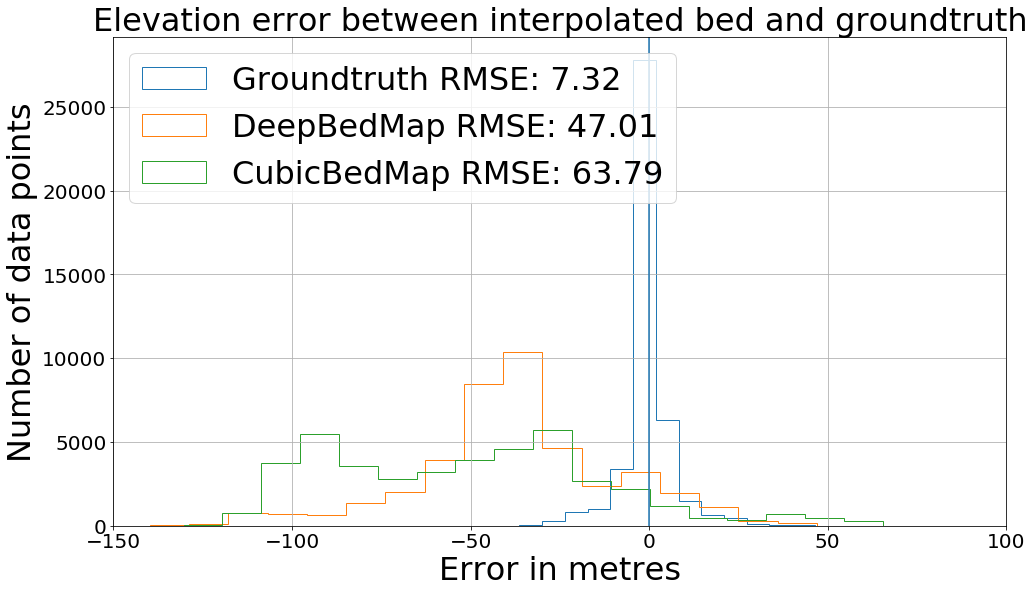

In [28]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
rmse_synthetichr = (df_synthetichr.error ** 2).mean() ** 0.5
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap:.2f}")

bins = 50

fig, ax = plt.subplots(figsize=(16, 9))
# ax.set_yscale(value="symlog")
ax.set_xlim(left=-150, right=100)
df_groundtruth.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"Groundtruth RMSE: {rmse_groundtruth:.2f}",
)
df_deepbedmap3.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"DeepBedMap RMSE: {rmse_deepbedmap3:.2f}",
)
df_cubicbedmap.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"CubicBedMap RMSE: {rmse_cubicbedmap:.2f}",
)
"""
df_synthetichr.hist(
    column="error",
    bins=bins,
    ax=ax,
    histtype="step",
    label=f"SyntheticHR RMSE: {rmse_synthetichr:.2f}",
)
"""

ax.set_title("Elevation error between interpolated bed and groundtruth", fontsize=32)
ax.set_xlabel("Error in metres", fontsize=32)
ax.set_ylabel("Number of data points", fontsize=32)
ax.legend(loc="upper left", fontsize=32)
plt.tick_params(axis="both", labelsize=20)
plt.axvline(x=0)

plt.savefig(fname="elevation_error_histogram.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [29]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_synthetichr = (df_synthetichr.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
print(f"Groundtruth RMSE: {rmse_groundtruth}")
print(f"DeepBedMap3 RMSE: {rmse_deepbedmap3}")
print(f"SyntheticHR RMSE: {rmse_synthetichr}")
print(f"CubicBedMap RMSE: {rmse_cubicbedmap}")
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap}")

Groundtruth RMSE: 7.318264583382579
DeepBedMap3 RMSE: 47.01085581824506
SyntheticHR RMSE: 156.96424205721797
CubicBedMap RMSE: 63.79470890727536
Difference      : -16.783853089030295


# **DeepBedMap** for the whole of Antarctica

In [30]:
# Bounding Box region in EPSG:3031 covering Antarctica
window_bound_big = rasterio.coords.BoundingBox(
    left=-2_700_000.0, bottom=-2_200_000.0, right=2_800_000.0, top=2_300_000.0
)
print(window_bound_big)

BoundingBox(left=-2700000.0, bottom=-2200000.0, right=2800000.0, top=2300000.0)


Tiling: lowres/bedmap2_bed.tif ... 

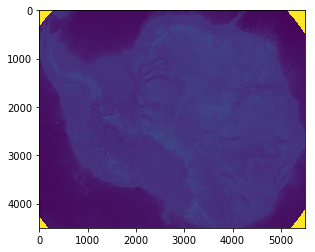

WARN: Tile has missing data, try passing in gapfill_raster_filepath
done!
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif ... done!
Tiling: misc/REMA_100m_dem.tif ... done!


In [31]:
X_tile, W1_tile, W2_tile = get_deepbedmap_model_inputs(window_bound=window_bound_big)

In [32]:
# Oh we will definitely need a GPU for this
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model.to_gpu()

In [33]:
# special zero padding for REMA, 5 pixels on top and bottom, 10 pixels on left and right
W1_tile = np.pad(
    array=W1_tile, pad_width=[(0, 0), (0, 0), (5, 5), (10, 10)], mode="constant"
)

In [34]:
print(X_tile.shape, W1_tile.shape, W2_tile.shape)

(1, 1, 4502, 5502) (1, 1, 45020, 55020) (1, 1, 9004, 11004)


## The whole of Antarctica tiler and predictor!!

Antarctica won't fit into our 16GB of GPU memory, so we have to:

1. Cut a 1000x1000 tile and load the data within this one small tile into GPU memory
2. Use our GPU-enabled model to make a prediction for this tile area
3. Repeat (1) and (2) for every tile we have covering Antarctica

In [35]:
# The whole of Antarctica tile and predictor
if 1 == 1:
    # Size are in kilometres
    final_shape = (18000, 22000)  # 4x that of BEDMAP2
    ary_height, ary_width = (1000, 1000)
    stride_height, stride_width = (1000, 1000)

    Y_hat = np.full(
        shape=(1, final_shape[0] + 20, final_shape[1] + 20),
        fill_value=np.nan,
        dtype=np.float32,
    )

    for y_step in range(0, final_shape[0], stride_height):
        for x_step in range(0, final_shape[1], stride_width):
            # plus 1 pixel on left and right
            x0, x1 = ((x_step // 4), ((x_step + ary_width) // 4) + 2)
            # plus 1 pixel on bottom and top
            y0, y1 = ((y_step // 4), ((y_step + ary_height) // 4) + 2)
            # x0, y0, x1, y1 = (3000,3000,3250,3250)

            X_tile_crop = cupy.asarray(a=X_tile[:, :, y0:y1, x0:x1], dtype="float32")
            W1_tile_crop = cupy.asarray(
                a=W1_tile[:, :, y0 * 10 : y1 * 10, x0 * 10 : x1 * 10], dtype="float32"
            )
            W2_tile_crop = cupy.asarray(
                a=W2_tile[:, :, y0 * 2 : y1 * 2, x0 * 2 : x1 * 2], dtype="float32"
            )

            Y_pred = model.forward(x=X_tile_crop, w1=W1_tile_crop, w2=W2_tile_crop)
            try:
                Y_hat[
                    :, (y0 * 4) + 4 : (y1 * 4) - 4, (x0 * 4) + 4 : (x1 * 4) - 4
                ] = cupy.asnumpy(Y_pred.array[0, :, :, :])
                # print(x0, y0, x1, y1)
            except ValueError:
                raise
            finally:
                X_tile_crop = W1_tile_crop = W2_tile_crop = None

    Y_hat = Y_hat[:, 10:-10, 10:-10]

## Save full map to file

In [36]:
# Save BEDMAP3 to GeoTiff and NetCDF format
# Using int16 instead of float32 to keep things smaller
save_array_to_grid(
    window_bound=window_bound_big,
    array=np.expand_dims(Y_hat.astype(dtype=np.int16), axis=0),
    outfilepath="model/deepbedmap3_big_int16",
    dtype=np.int16,
)

## Show *the* DeepBedMap

In [37]:
with rasterio.open("model/deepbedmap3_big_int16.tif") as raster_tiff:
    deepbedmap_dem = raster_tiff.read(indexes=1, masked=True)

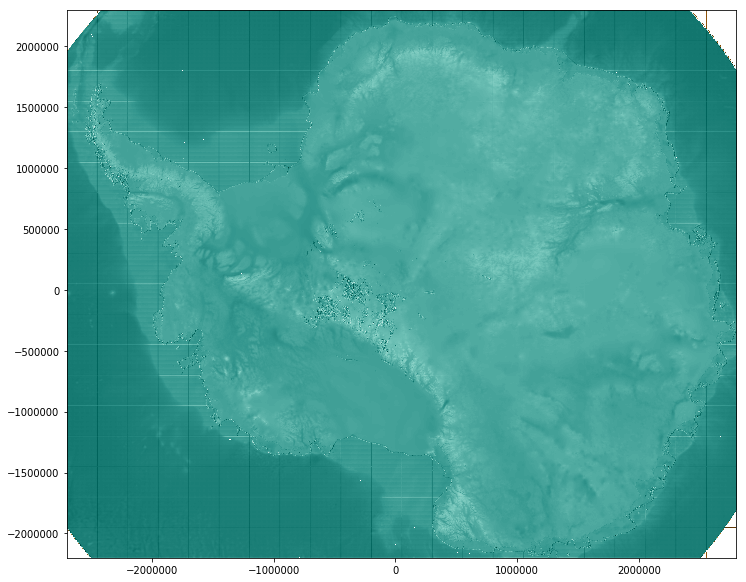

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=True, figsize=(12, 12))
rasterio.plot.show(
    source=np.ma.masked_less(x=deepbedmap_dem, value=-10000, copy=False),
    transform=raster_tiff.transform,
    cmap="BrBG_r",
    ax=ax,
)